## Doppler Ultrasound

We are first going to simulate the pulses that are leaving our transducer. Diagnostic ultrasound frequencies are from 1-20 MHz, however, for our specific use case of
aortic


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Ultrasounds come in all types of shapes and forms. We have chosen a simplified model where the frequency of the transducer is 1 Mhz and it has a pulse width of 5 * wavelength. With this information, we are able to create a time array and a choose an arbitrary dt that can best represent our output signals from the transducer.

In [6]:
# Initialize the Transducer Characteristics and Common Time Array
freq_t = 1E6 # 1 MHz transducer
wavelength = 1/freq_t # this is intrinsic to our system
pulsewidth = 5 * wavelength # this is intrinsic to our system
PRF = 10E3 # aka pulse repetition frequency, 10 kHz the high end
btwnpulse = 1/PRF # this will be what we change depending on the speed of the RBCs

t = np.arange(0,(pulsewidth+btwnpulse)*4,1E-8); # 1/(1E-8) will be our sampling frequency, I believe

Like we said before, ultrasounds come in many forms, some are continuously outputting and receiving, some are pulse widths. We had chosen the pulse width as stated before. Now we will create a function that is able to easily create these pulses. We chose a rect as our envelope for simplicity.

Text(0.5, 1.0, 'Waveforms being sent out by Tranducer')

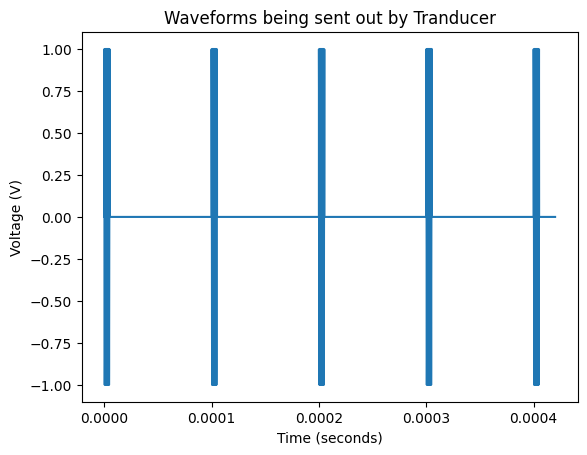

In [7]:
rect = t*0
rects = t*0

for n in np.arange(0,5,1): # making the pulse waves and their frequencies
   newrect = (t<pulsewidth+btwnpulse*n)*1*(t>btwnpulse*(n))*np.cos(2*np.pi*1E6*(t-n*btwnpulse))
   rects = rects + newrect

transduceroutput = rects # this is what we are sending out 
plt.plot(t,transduceroutput)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('Waveforms being sent out by Tranducer')

Now, we want to simulate the pulses coming back to the transducer. There is an equation, defined as Fd in the coding box that is used. We have to calculate the change of frequency for a given speed and then find the period, in order to easily graph it. We want to simulate a healthy person's aorta at 1.5 m/s, 2 m/s for a mild aortic stenosis, 3 m/s for moderate aortic stenosis, and 5 m/s for severe aortic stenosis. Make an example of moderate aortic stenosis that has a velocity of -3 m/s.

In [47]:
# Initialize the Transducer Characteristics and Common Time Array
freq_t = 1E6 # 1 MHz transducer
wavelength = 1/freq_t # this is intrinsic to our system
pulsewidth = 5 * wavelength # this is intrinsic to our system
PRF = 10E3
btwnpulse = 1/PRF

t = np.arange(0,(pulsewidth+btwnpulse)*10,1E-8)

def makepulses(t,velocity,theta,reps,pulsewidth,btwnpulse): # t is an array, velocity in m/s
    rects = t*0
    Fd = 2*1E6*(velocity/1540)*np.cos(theta)
    btwnpulse_freq = 10E3 + Fd
    btwnpulse = 1/btwnpulse_freq
    for n in np.arange(0,reps,1): # making the pulse waves and their frequencies
        newrect = (t<pulsewidth+btwnpulse*n)*1*(t>btwnpulse*(n))*np.cos(2*np.pi*1E6*(t-n*btwnpulse))
        rects = rects + newrect

    return rects

healthy = makepulses(t,1.5,0,15,pulsewidth,btwnpulse)
mild = makepulses(t,2,0,15,pulsewidth,btwnpulse)
mod = makepulses(t,3,0,15,pulsewidth,btwnpulse)
severe = makepulses(t,5,0,25,pulsewidth,btwnpulse)
modrev = makepulses(t,-3,0,25,pulsewidth,btwnpulse)

Take the Fourier transform to confirm the frequency of the transducer. Notice there are harmonics that appear about every 0.2 MHz. These are caused by the rect envelope having a length of 5*wavelength.

Formula for doppler: velocity = c(Fr - Ft)/(2 * F0 * cos(theta))

Text(0.5, 1.0, 'Fourier Transform')

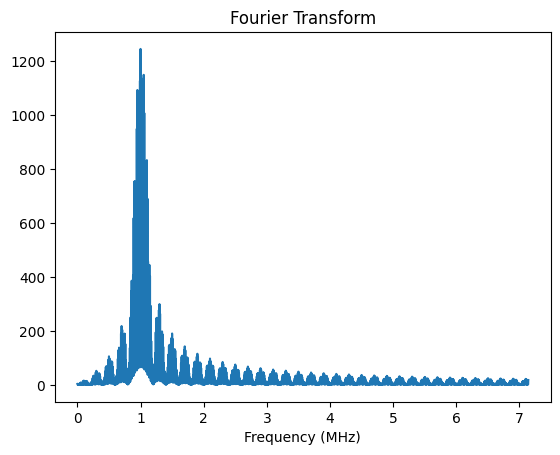

In [48]:
time = t[1] - t[0]
#Take fourier transform
freq = np.fft.fftshift(np.fft.fftfreq(len(transduceroutput), time))
freq_transducer = np.abs(np.fft.fftshift(np.fft.fft(transduceroutput)))
length = len(freq) //2
#only capture up to 7MHz
plt.plot(freq[length:length+3000]/1e6, freq_transducer[length:length+3000])
plt.xlabel("Frequency (MHz)")
plt.title("Fourier Transform")

For each of the transducer inputs for the blood flow, reverse engineer to find the time between the peaks. Convert to find the frequency shift and then use the Doppler equation to find the velocity. Then use the formula in the next box to find the pressure and determine if there is a stenosis. Scipy find_peaks has been used to identify the peaks and then find the time between peaks. It is observed that for the healthy case there is the largest period, and as stenosis increases the frequency will increase (period will decrease).

## Healthy Reconstruction

Average time between peaks: 8.377916666666666e-05
Frequency:  1936.1416422141551
Velocity in m/s: 1.4908290645048996


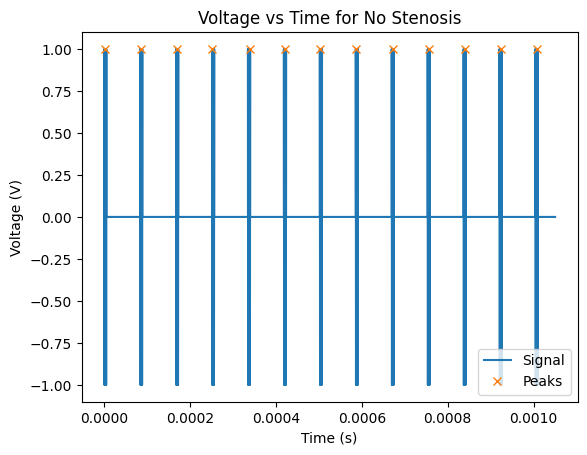

In [71]:
# Find the peaks in the 'healthy' signal with a minimum distance of 1000 data points between peaks
peaks, _ = find_peaks(healthy, distance=1000)

# Calculate the time of each peak
peak_times = t[peaks]  # Extract the times corresponding to the peaks

# Calculate the time differences between consecutive peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_healthy = np.mean(time_diffs)

# Compute the frequency using the formula: Fd = (1 - average_time * 10^4) / average_time
Fd = (1 - average_time_between_peaks_healthy * 10**4) / average_time_between_peaks_healthy
print("Average time between peaks:", average_time_between_peaks_healthy)
print("Frequency: ", Fd)

# Assume the speed of sound in tissue is 1540 m/s
c = 1540

# Compute the velocity of blood flow using the formula: velocity = c * Fd / (2 * 10^6)
velocity_healthy = c * Fd / (2 * 1e6)
print("Velocity in m/s:", velocity_healthy)

# Plot the healthy signal and mark the peaks
plt.plot(t, healthy, label='Signal')
plt.plot(t[peaks], healthy[peaks], 'x', label='Peaks')  # Mark the peaks with 'x'
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for No Stenosis')
plt.legend()
plt.show()

Pressure Calculation:
Use simplified Bernoulli Equation: P = 4v^2 to convert velocity to pressure to diagnose stenosis

Pressure should be less than 20 mmHg for a healthy/mild stenosis

In [50]:
# Calculate the pressure for a healthy condition using the simplified Bernoulli equation
pressure_healthy = 4*velocity_healthy**2
print("Pressure is: ", pressure_healthy, 'mmHg')

Pressure is:  8.890285198290217 mmHg


## Mild Reconstruction

Average time between peaks: 7.930461538461539e-05
Frequency:  2609.6065802746953
Velocity in m/s: 2.0093970668115153


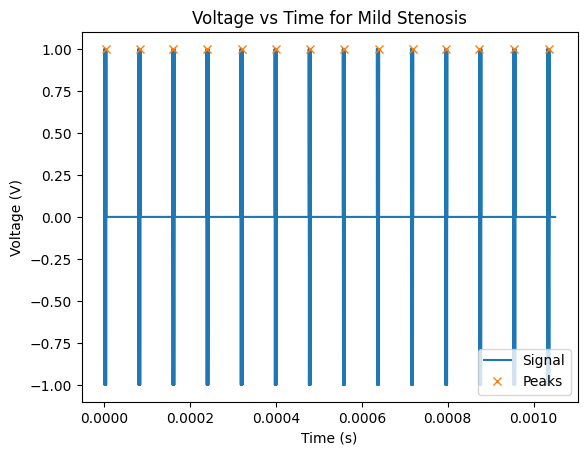

In [74]:
# Find the peaks in the 'mild' signal with a minimum distance of 1000 data points between peaks
peaks, _ = find_peaks(mild, distance=1000)

# Calculate the time of each peak
peak_times = t[peaks]  # Extract the times corresponding to the peaks

# Calculate the time differences between consecutive peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_mild = np.mean(time_diffs)

# Compute the frequency using the formula: Fd = (1 - average_time * 10^4) / average_time
Fd = (1 - average_time_between_peaks_mild * 10**4) / average_time_between_peaks_mild
print("Average time between peaks:", average_time_between_peaks_mild)
print("Frequency: ", Fd)

# Assume the speed of sound in tissue is 1540 m/s
c = 1540

# Compute the velocity of blood flow using the formula: velocity = c * Fd / (2 * 10^6)
velocity_mild = c * Fd / (2 * 1e6)
print("Velocity in m/s:", velocity_mild)

# Plot the mild signal and mark the peaks
plt.plot(t, mild, label='Signal')
plt.plot(t[peaks], mild[peaks], 'x', label='Peaks')  # Mark the peaks with 'x'
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Mild Stenosis')
plt.legend(loc='lower right')
plt.show()


Pressure Calculation:
Use simplified Bernoulli Equation: P = 4v^2 to convert velocity to pressure to diagnose stenosis

Pressure should be less than 20 mmHg for a healthy/mild stenosis

In [52]:
# Calculate the pressure for a mild stenosis condition using the simplified Bernoulli equation
pressure_mild = 4*velocity_mild**2
print("Pressure is: ", pressure_mild, 'mmHg')

Pressure is:  16.150706288442887 mmHg


## Moderate Reconstruction

Average time between peaks: 7.217714285714285e-05
Frequency:  3854.801678410262
Velocity in m/s: 2.9681972923759017


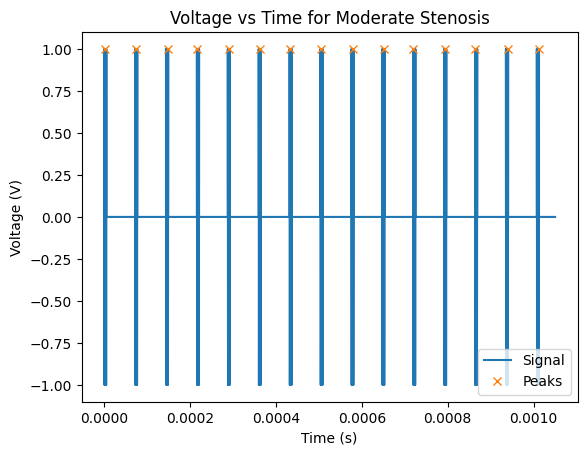

In [75]:
# Find the peaks in the 'mod' signal with a minimum distance of 1000 data points between peaks
peaks, _ = find_peaks(mod, distance=1000)

# Calculate the time of each peak
peak_times = t[peaks]  # Extract the times corresponding to the peaks

# Calculate the time differences between consecutive peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_mod = np.mean(time_diffs)

# Compute the frequency using the formula: Fd = (1 - average_time * 10^4) / average_time
Fd = (1 - average_time_between_peaks_mod * 10**4) / average_time_between_peaks_mod
print("Average time between peaks:", average_time_between_peaks_mod)
print("Frequency: ", Fd)

# Assume the speed of sound in tissue is 1540 m/s
c = 1540

# Compute the velocity of blood flow using the formula: velocity = c * Fd / (2 * 10^6)
velocity_mod = c * Fd / (2 * 1e6)
print("Velocity in m/s:", velocity_mod)

# Plot the 'mod' signal and mark the peaks
plt.plot(t, mod, label='Signal')
plt.plot(t[peaks], mod[peaks], 'x', label='Peaks')  # Mark the peaks with 'x'
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Moderate Stenosis')
plt.legend()
plt.show()

Pressure Calculation:
Use simplified Bernoulli Equation: P = 4v^2 to convert velocity to pressure to diagnose stenosis

Pressure should be between 20-50 mmHg for a moderate stenosis

In [54]:
# Calculate the pressure for a moderate stenosis condition using the simplified Bernoulli equation
pressure_mod = 4*velocity_mod**2
print("Pressure is: ", pressure_mod, 'mmHg')

Pressure is:  35.24078066587054 mmHg


## Severe Reconstruction

Average time between peaks: 6.051235294117647e-05
Frequency:  6525.551418767196
Velocity in m/s: 5.024674592450741


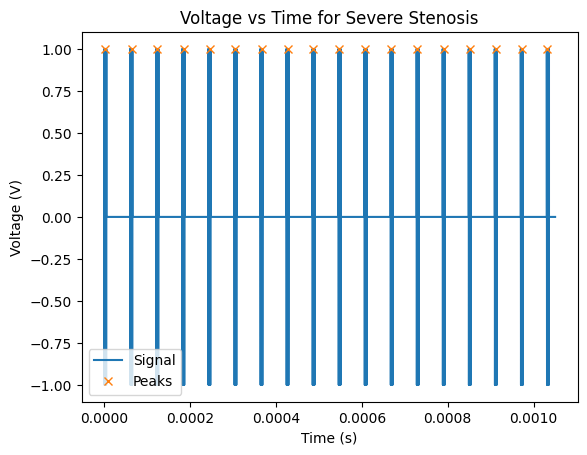

In [78]:
# Find the peaks in the 'severe' signal with a minimum distance of 1000 data points between peaks
peaks, _ = find_peaks(severe, distance=1000)

# Calculate the time of each peak
peak_times = t[peaks]  # Extract the times corresponding to the peaks

# Calculate the time differences between consecutive peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks_severe = np.mean(time_diffs)

# Compute the frequency using the formula: Fd = (1 - average_time * 10^4) / average_time
Fd = (1 - average_time_between_peaks_severe * 10**4) / average_time_between_peaks_severe
print("Average time between peaks:", average_time_between_peaks_severe)
print("Frequency: ", Fd)

# Assume the speed of sound in tissue is 1540 m/s
c = 1540

# Compute the velocity of blood flow using the formula: velocity = c * Fd / (2 * 10^6)
velocity_severe = c * Fd / (2 * 1e6)
print("Velocity in m/s:", velocity_severe)

# Plot the 'severe' signal and mark the peaks
plt.plot(t, severe, label='Signal')
plt.plot(t[peaks], severe[peaks], 'x', label='Peaks')  # Mark the peaks with 'x'
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs Time for Severe Stenosis')
plt.legend()
plt.show()

Pressure Calculation:
Use simplified Bernoulli Equation: P = 4v^2 to convert velocity to pressure to diagnose stenosis

Pressure should be greater than 50 mmHg for a severe stenosis

In [56]:
# Calculate the pressure for a severe stenosis condition using the simplified Bernoulli equation
pressure_severe = 4*velocity_severe**2
print("Pressure is: ", pressure_severe, 'mmHg')

Pressure is:  100.98941904008008 mmHg


## Parameter Sweep of Angles

To determine what the optimal angle is for the ultrasound transducer to send out waveforms to the blood flow, we will perform a parameter sweep. This parameter sweep is on the healthy data set, so the velocity should be 1.5 m/s. Perform a parameter sweep using the Doppler equation with angles from 0 to 90 (excluding 90 as dividing by cos(90) results in a divide by zero error). Make sure to convert to radians before using cosine.

Average time between peaks: 8.377916666666666e-05
Frequency:  1936.1416422141551


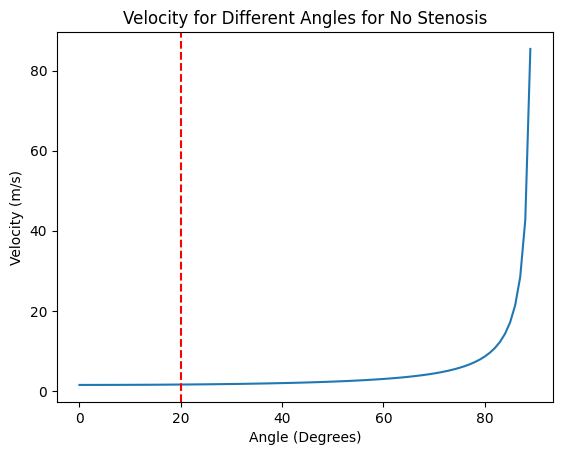

In [79]:
peaks, _ = find_peaks(healthy, distance=1000)

# Calculate the time of each peak
peak_times = t[peaks]  # Extract the times corresponding to the peaks

# Calculate the time differences between consecutive peaks
time_diffs = np.diff(peak_times)  # Time differences between peaks

# Compute the average time between peaks
average_time_between_peaks = np.mean(time_diffs)

# Compute the frequency using the formula: Fd = (1 - average_time * 10^4) / average_time
Fd = (1 - average_time_between_peaks * 10**4) / average_time_between_peaks
print("Average time between peaks:", average_time_between_peaks)
print("Frequency: ", Fd)

# Generate an array of angles from 0 to 90 degrees
angles = np.arange(0, 90)
# Convert the angles to radians for calculation
angles_radians = np.radians(angles)

# Assume the speed of sound in tissue is 1540 m/s
c = 1540

# Compute the velocity of blood flow for different angles using the Doppler equation
velocity_healthy_angle = c * Fd / (2 * 1e6 * np.cos(angles_radians))

# Plot the velocity as a function of angle
plt.plot(angles, velocity_healthy_angle)
# Add a vertical line at 20 degrees for reference
plt.axvline(x=20, color='r', linestyle='--', label='20 degrees')
plt.title('Velocity for Different Angles for No Stenosis')
plt.xlabel("Angle (Degrees)")
plt.ylabel('Velocity (m/s)')
plt.show()

It should be observed that velcoity rapidly increases after about 30 degrees. The clinical accepted value for the ultrasound transducer angle is anything less than 20 degrees.

## Analyzing Direction of Flow

Although this may seem like an arbitrary graph, this was useful in checking our code because the way we graphed the distances between the pulses before, with negative velocities, the period was shown as negative. Thus, we changed from calculating periods first, to finding the frequency first then getting the period between the pulses from that. This resolved that issue and was an affirmation that the code was correct.

/var/folders/ml/t178nbnd725dddr5rm6zzssm0000gp/T/ipykernel_64150/2109901258.py:21: RuntimeWarning: divide by zero encountered in divide
  btwnpulse_array2 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array2
/var/folders/ml/t178nbnd725dddr5rm6zzssm0000gp/T/ipykernel_64150/2109901258.py:42: RuntimeWarning: divide by zero encountered in divide
  btwnpulse_array4 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array4


Text(0, 0.5, 'Period of the Pulses')

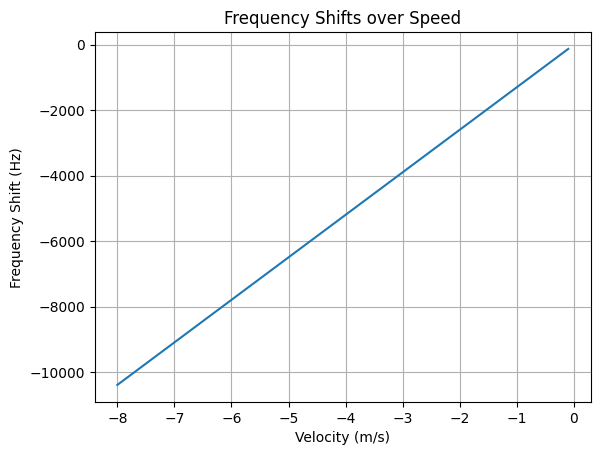

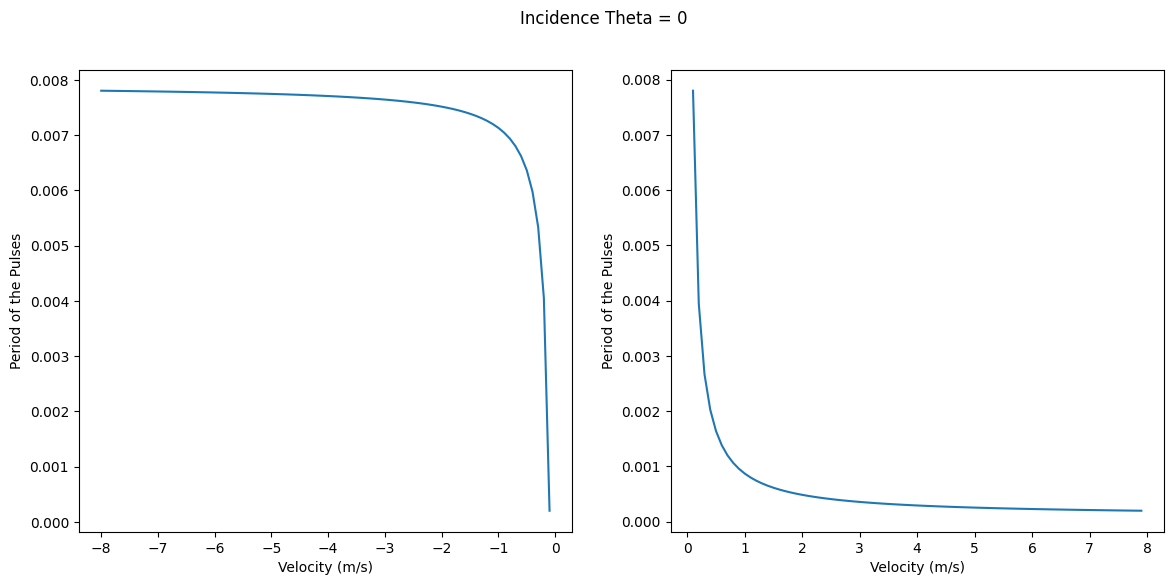

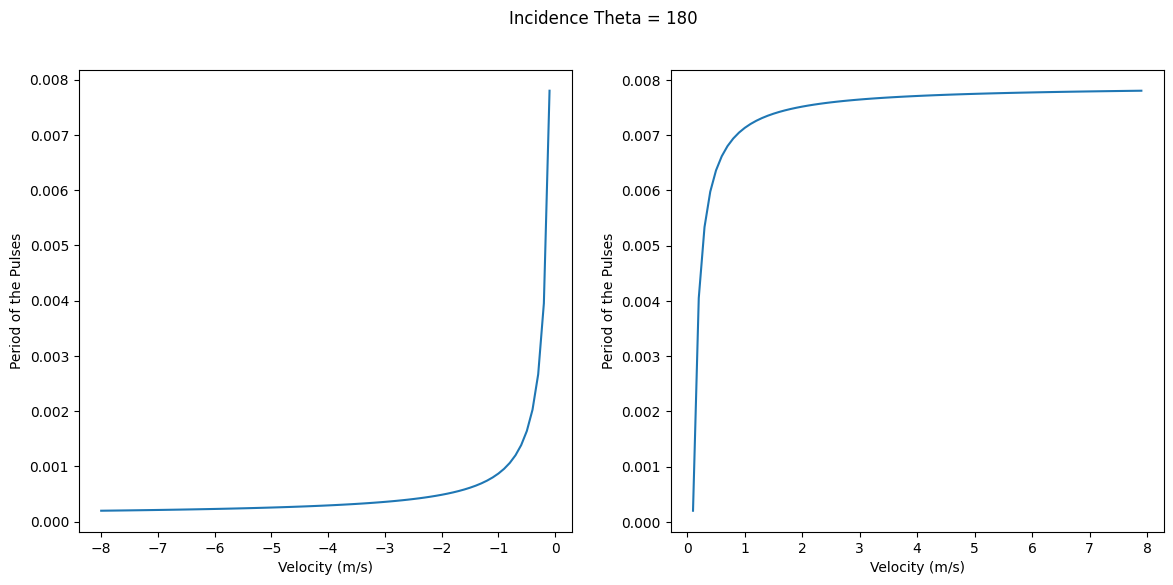

In [63]:
# Looking at Reverse Flow, want to demonstrate that you have to move the transducer once you know the anatomy. Can't just leave it there.
# Right now, we have the transducer moving toward the transducer.
dv = 0.1
velocity_array = np.arange(-8,0,dv) # in m/s
velocity_array2 = np.arange(0,8,dv)
#print((velocity_array))
theta = 0 # the blood flow is going directly towards
Fd_array = 2*1E6*(velocity_array/1540)*np.cos(theta)
Fd_array2 = 2*1E6*(velocity_array2/1540)*np.cos(theta)
plt.figure()
plt.plot(velocity_array,Fd_array)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Frequency Shift (Hz)')
plt.title('Frequency Shifts over Speed')
plt.grid()


# Notice how the frequency shifts are negative. This presents us a problem...
# Earlier we calculated the time between pulses, or the period
btwnpulse_array = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array
btwnpulse_array2 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array2
plt.figure(figsize=(14,6))
plt.suptitle('Incidence Theta = 0')
plt.subplot(1,2,1)
plt.plot(velocity_array,btwnpulse_array + 0.0078)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

plt.subplot(1,2,2)
plt.plot(velocity_array2,btwnpulse_array2)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')


# When we look at the graphs, we cannot have a negative period. Periods must be positive. Thus, it is up to the ultrasound technician to wiggle the ultrasound transducer to
# an angle whereby they can properly interpret the results. A solid understanding of anatomy and physiology is required.

theta2 = np.pi # the blood flow is going directly away
Fd_array3 = 2*1E6*(velocity_array/1540)*np.cos(theta2)
Fd_array4 = 2*1E6*(velocity_array2/1540)*np.cos(theta2)
btwnpulse_array3 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array3
btwnpulse_array4 = btwnpulse*np.ones(np.shape(velocity_array)[0]) + 1/Fd_array4
plt.figure(figsize=(14,6))
plt.suptitle('Incidence Theta = 180')
plt.subplot(1,2,1)
plt.plot(velocity_array,btwnpulse_array3)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

plt.subplot(1,2,2)
plt.plot(velocity_array2,btwnpulse_array4 + 0.0078)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Period of the Pulses')

# 180 degrees is when blood is going away, however, it is only valid for negative values of velocity. Again ,it is up to the technician to adjust the transducer
# to an angle which can read. Then based on the physiology, they can find out the direction of the blood, at least for pulse wave doppler. Maybe we need to explore continuous doppler.

## Aliasing

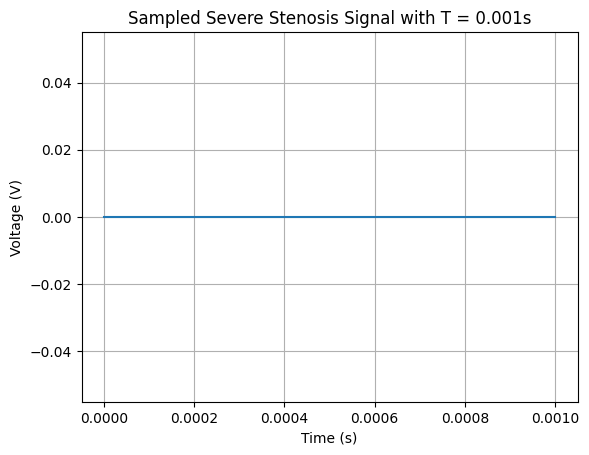

In [68]:
# Define the sampling period
sampling_period = 0.001

freq_t = 1E6 # 1 MHz transducer
wavelength = 1/freq_t # this is intrinsic to our system
pulsewidth = 5 * wavelength # this is intrinsic to our system
PRF = 10E3
btwnpulse = 1/PRF

t = np.arange(0,(pulsewidth+btwnpulse)*10,1E-8)# Create a new time array with the specified sampling period
t_sampled = np.arange(0, t[-1], sampling_period)
# Sample the signal at the specified intervals
signal_sampled = np.interp(t_sampled, t, severe)

# Plot the sampled signal
plt.plot(t_sampled, signal_sampled)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Sampled Severe Stenosis Signal with T = 0.001s')
plt.grid(True)
plt.show()

When we sample at a period of 0.001s (frequency of 1 kHz), we do not capture any of the inbound signal since the signal is for such a small duration (5 * lambda). This completely misses the original signal, aliasing it. 

Text(0.5, 1.0, 'Sampled Severe Stenosis Signal with T = 0.000001s')

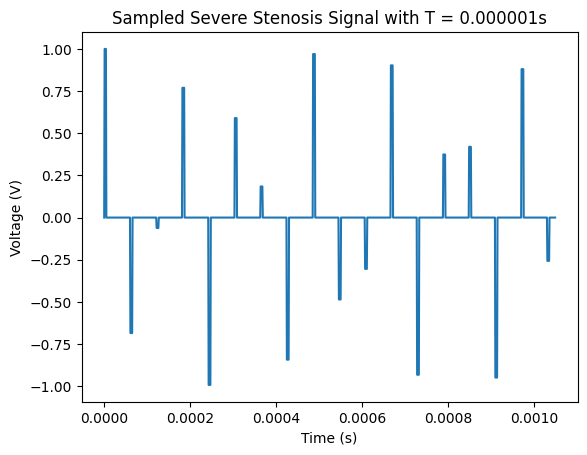

In [69]:
# Define the sampling period
sampling_period = 0.000001

# Create a new time array with the specified sampling period
t_sampled = np.arange(0, t[-1], sampling_period)

# Sample the signal at the specified intervals
signal_sampled = np.interp(t_sampled, t, severe)

# Plot the sampled signal
plt.plot(t_sampled, signal_sampled)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Sampled Severe Stenosis Signal with T = 0.000001s')

When we decrease the period to 0.000001 (1 MHz), we capture more of the signal, but it appears as if the signal occurs at a lower frequency than it does. This type of aliasing can be dangerous, since it systemically underestimates the velocity of the blood and thus the pressure. This can lead to false negative diagnosis.

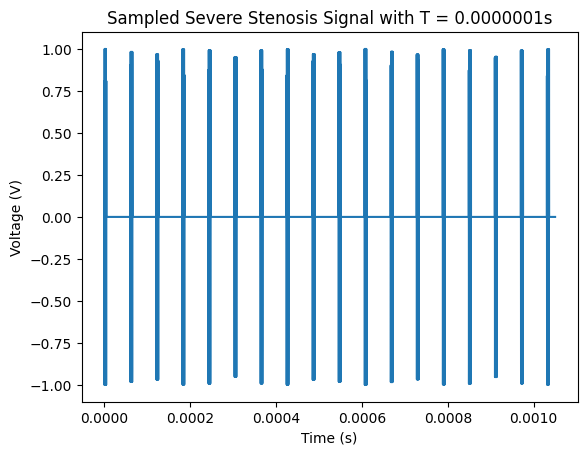

In [70]:
# Define the sampling period
sampling_period = 0.0000001

# Create a new time array with the specified sampling period
t_sampled = np.arange(0, t[-1], sampling_period)

# Sample the signal at the specified intervals
signal_sampled = np.interp(t_sampled, t, severe)

# Plot the sampled signal
plt.plot(t_sampled, signal_sampled)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Sampled Severe Stenosis Signal with T = 0.0000001s')
plt.show()

When we decrease the period to 0.0000001 (10 MHz), we capture the important characteristics of the signal in its entirety. It should be noted that this is an extremely high sampling rate, which may be limited by the microprocessors in our circuit or other components. We should chose a sampling frequency that is high enough for the most severe types of stenosis. 